# Convergence tests for finite differencing
If a finite differencing method is applied correctly, then as the discretization size goes to zero, we should see that
the solution converges. This means that we should find that as the step size $\Delta t$ is made smaller, the effect of that change should make a smaller change on the solution produced. We will simulate the system forward a certain amount of time at a given time step $\Delta t$, we will then halve the time step and run the same simulation. This will produce two different results, where hopefully the second is more accurate. We will measure the norm difference between these results and then continue halving $\Delta t$, the desired result is that as we keep on halving $\Delta t$, the normed difference should go to zero.

In [1]:
using PyPlot
using ForwardDiff
# Change this to the location of finiteDifferences.jl on your machine.
include("C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\src\\finiteDifferences.jl")
using FiniteDifferences

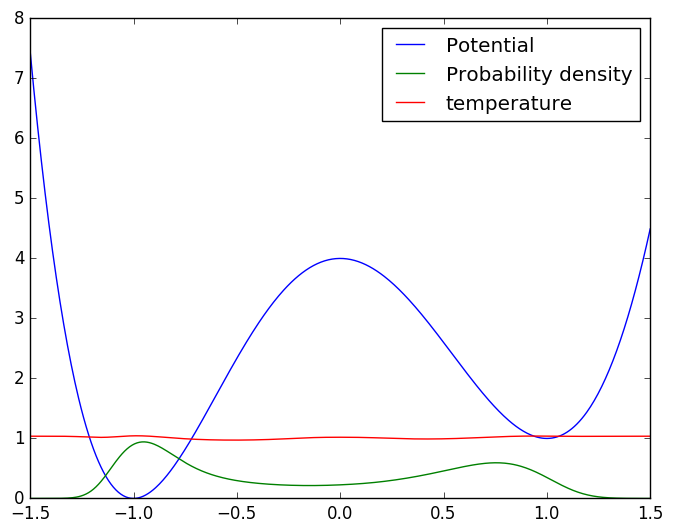

  1.841608 seconds (2.04 M allocations: 2.256 GB, 15.68% gc time)


PyObject <matplotlib.legend.Legend object at 0x000000001E3C22E8>

In [2]:
# Initialize the system and plot an example evolution.
LL = 1.0  # Length scale of the system.
T0 = 1.0  # Temperature. 

alpha = 1e-2
beta = 0.0001

nPoints = 500 # The number of points on the xAxis
nSteps = 5000
dt = 1e-5  # Time step.

extend = 1.5
xAxis = linspace(-extend*LL, extend*LL, nPoints)
dx = (xAxis[end] - xAxis[1])/nPoints # Grid spacing

coeff = hermite_coeff([-1.0, 0.0, 1.0], [0.0, 8.0, 2.0], [0.0, 0.0, 0.0])
function V(x, coeff)
    acc = 0
    for ii = 1:length(coeff)
        acc += coeff[ii]*x^(ii-1)
    end
    acc
end
V(x) = V(x, coeff)
dV(x) = ForwardDiff.derivative(V, x)

potential = Float64[V(x) for x in xAxis]
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]

tempFun(x) = T0
temperature = Float64[tempFun(x) for x in xAxis]

sigma  = 0.1
P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - 0.0)^2)/(2sigma^2))
              for x in xAxis]
P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
density = P0

T = Array(Float64, nPoints, nSteps)
T[:, 1] = temperature
P = Array(Float64, nPoints, nSteps)
P[:, 1] = density
energy = energyFun(potential, density, temperature, alpha, xAxis)
@time begin
    for i in 2:nSteps
        density = stepP(density, dt, dpotential, temperature, xAxis; bndType = :absorbing, normalization = true)
        temperature = stepT(temperature, dt, density, potential, dpotential, alpha,
            beta, energy, xAxis; bndType=:neumann)
    end
end

plot(xAxis, 0.5potential, xAxis, density, xAxis, temperature)
legend(["Potential", "Probability density", "temperature"])

Probability convergence rate = -20.65822818900101


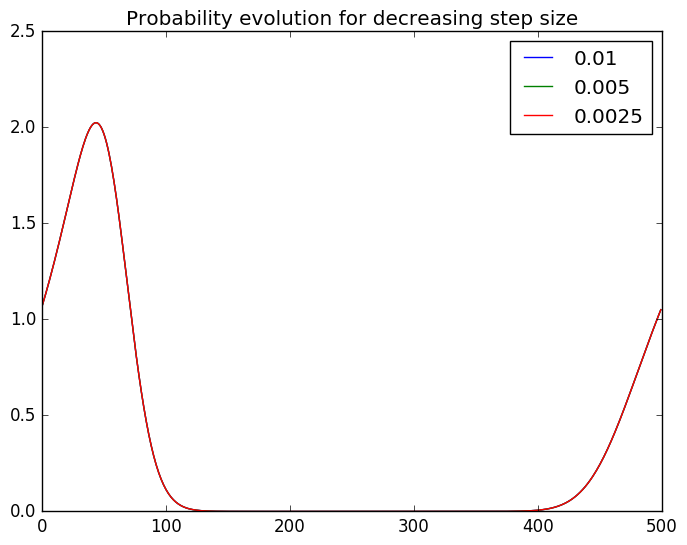

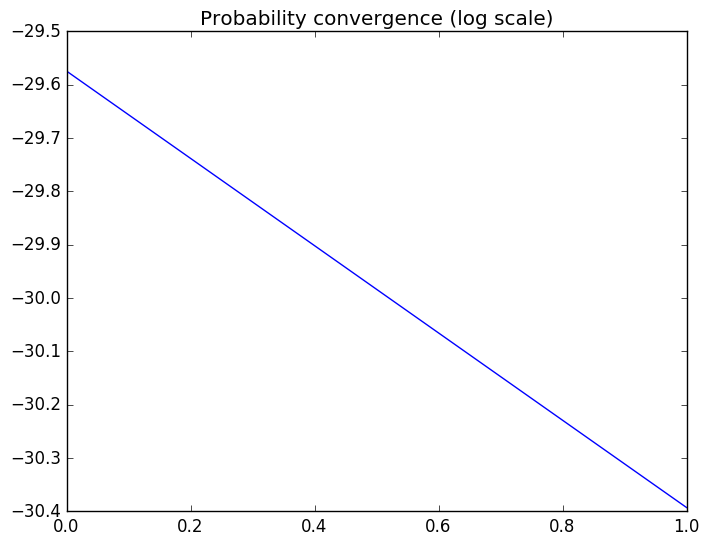

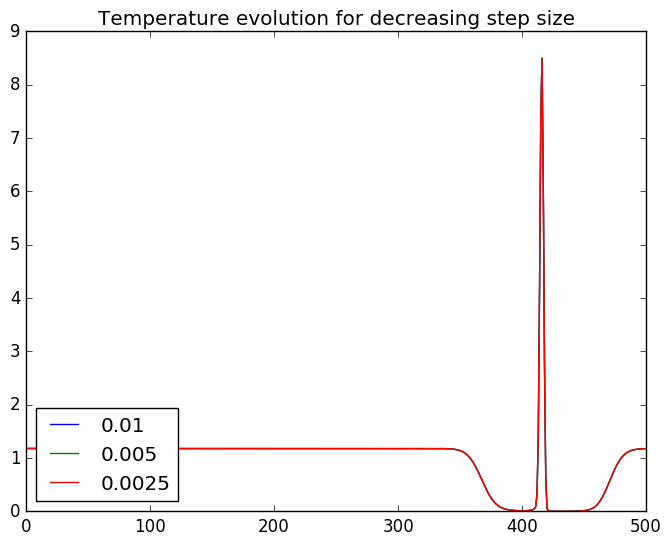

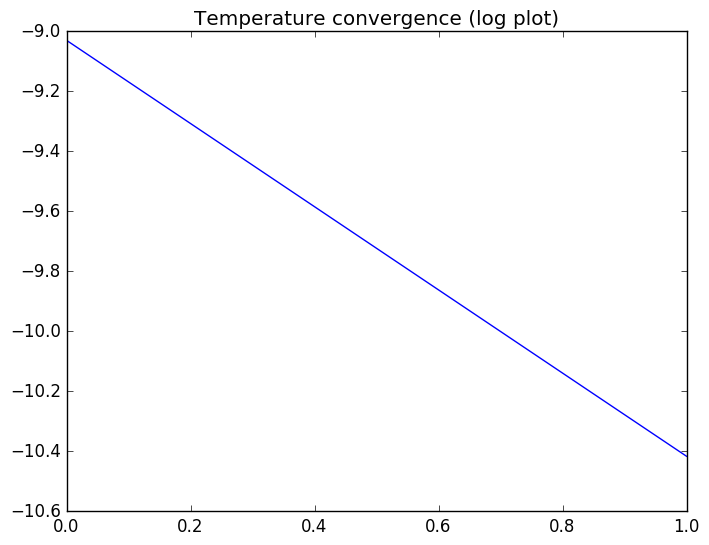

Temperature convergence rate = 0.1807363671617464


PyObject <matplotlib.text.Text object at 0x000000001ED55198>

In [3]:
# Test for convergence, we will test the convergence of the stepP and the stepT functions seperately, the temperature
# case is a little un-physical (Brownian particle is not moving but there is still heat?). I have only included it as
# a way to test the numerics.
T0 = 1.0  # Temperature.
alpha = 1e-2
beta = 1e-4
evolveTime = 2.0
scaling = 1e-2
dtVec = [1, 1/2, 1/4]*scaling  

sigma  = 0.1
P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - 1.0)^2)/(2sigma^2))
              for x in xAxis]
P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
tempFun(x) = T0
temperature = Float64[tempFun(x) for x in xAxis]

density = P0
Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
index = 1
energy = energyFun(potential, density, temperature, alpha, xAxis)
for dt in dtVec
    Parray[:, index] = evolveP(density, evolveTime, dt, dpotential,
                                temperature, xAxis)
    Tarray[:, index] = evolveT(temperature::AbstractArray, evolveTime, dt,
                            potential, dpotential, density, alpha, beta, energy, xAxis)
    index += 1
end
# Calculate the distances between adjacent probability distributions.
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray)
title("Probability evolution for decreasing step size")
legend(dtVec)
figure()
plot(log(norms))
title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
figure()
plot(log(norms))
title("Temperature convergence (log plot)")

As you can see, the periodic boundary conditions are causing the system to do some very wierd things, I think that the same wierd things are happening with absorbing boundary conditions, but their effect is harder to visualize.

Probability convergence rate = 8.323366507479001


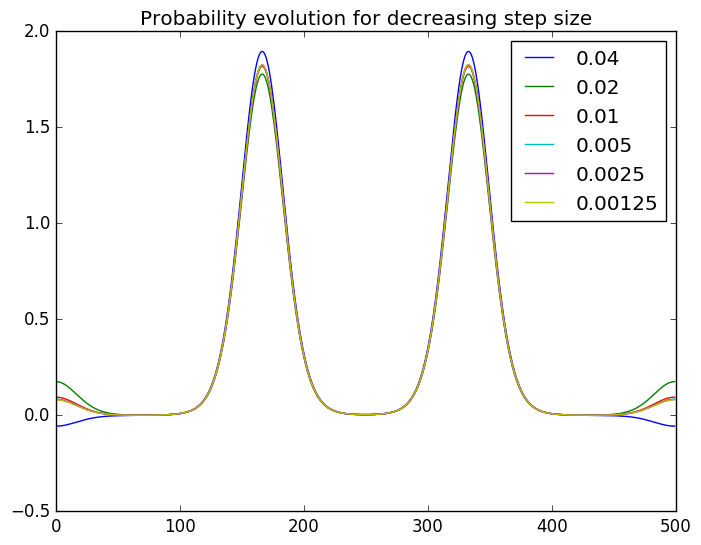

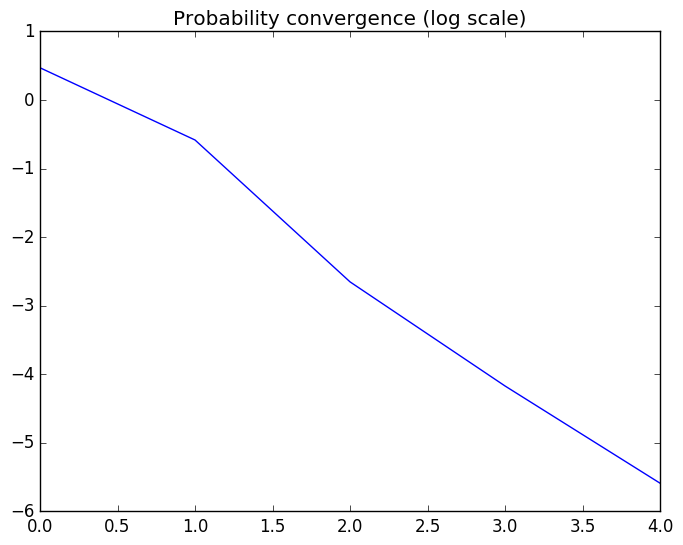

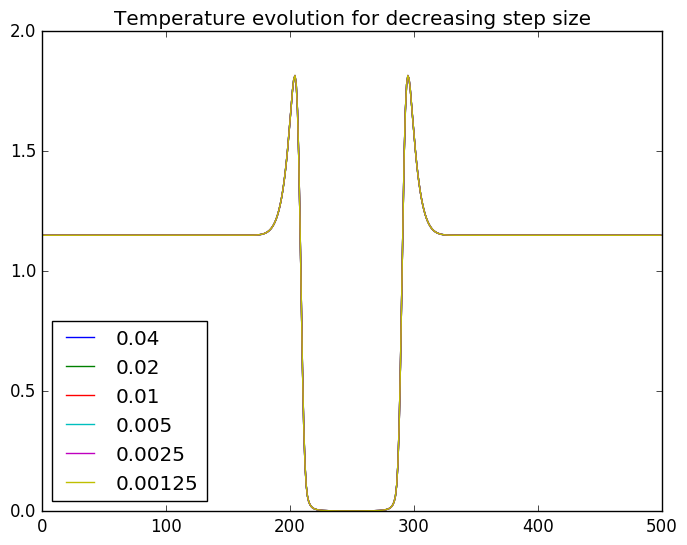

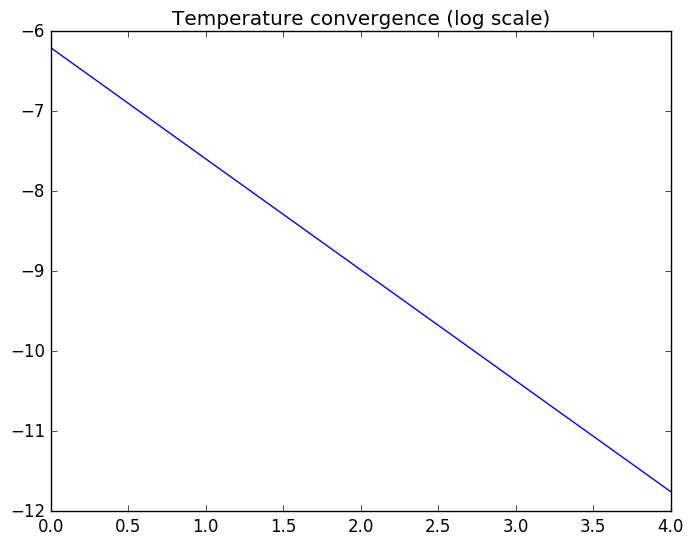

Temperature convergence rate = 1.6489711005753285


PyObject <matplotlib.text.Text object at 0x0000000027AE53C8>

In [4]:
# Test the convergence rate for a different potential.
scaling = 1e-2
dtVec = [4.0, 2.0, 1.0, 1/2, 1/4, 1/8]*scaling
V(x) = 2cos(2pi*x)
dV(x) = ForwardDiff.derivative(V, x)
potential = Float64[V(x) for x in xAxis]
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]
density = Float64[(1/(sigma*sqrt(2pi)))*exp(-(x^2)/(2sigma^2))
              for x in xAxis]

Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
index = 1
energy = energyFun(potential, density, temperature, alpha, xAxis)
for dt in dtVec
    Parray[:, index] = evolveP(density, evolveTime, dt, dpotential,
                            temperature, xAxis; probBndType = :periodic)
    Tarray[:, index] = evolveT(temperature::AbstractArray, evolveTime::Number, dt::Number,
                            potential, dpotential, density, alpha, beta, energy, xAxis)
    index += 1
end
# Calculate the distances between adjacent probability distributions.
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray)
title("Probability evolution for decreasing step size")
legend(dtVec)
figure()
plot(log(norms))
title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
figure()
plot(log(norms))
title("Temperature convergence (log scale)")

In [5]:
function stepT(temperature::AbstractArray, dt::Number,
            density::AbstractArray, potential::AbstractArray,
            dpotential::AbstractArray, alpha::Number,
            beta::Number, energy::Number,
            xAxis::AbstractArray; bndType::Symbol=:neumann)
    # Augment the discrete density since we will be
    # evaluating them at points beyond the boundary.
    # The density is periodic.
    density = [density[end] ; density ; density[1]]

    n_points = length(xAxis)
    dx = (xAxis[end] - xAxis[1])/n_points
    rr = dt/(dx^2)
    # The inhomogeniety at the end of the equation.
    in_homo = -rr*alpha*density[2:end-1].*(dpotential[2:end-1].^2)*dx^2
    # The diagonals of the matrix.
    diag_minus1 = rr*(-0.5*alpha*density[1:end-3].*dpotential[2:end-2]*dx + beta)
    diag0 = -2*beta*rr*ones(xAxis)
    diag1 = rr*(0.5*alpha*density[4:end].*dpotential[3:end-1]*dx + beta)
    # Add the inhomogeneity to the diagonals.
    diag_minus1 += in_homo[2:end]
    diag0 += in_homo
    diag1 += in_homo[1:end-1]

    if bndType == :absorbing
        A = Tridiagonal(diag_minus1, diag0, diag1)
        II = Tridiagonal(zeros(diag1), ones(diag0), zeros(diag1))
        temperature = (II - 0.5A)\((II + 0.5A)*temperature)
    elseif bndType == :periodic
        A = spdiagm((diag_minus1, diag0, diag1), (-1, 0, 1))
        A[1, end] = diag_minus1[1]
        A[end, 1] = diag1[end]
        temperature = (speye(A) - 0.5A)\((speye(A) + 0.5A)*temperature)
    elseif bndType == :dirichlet
        A = spdiagm((diag_minus1, diag0, diag1), (-1, 0, 1))
        B = speye(A) + 0.5A
        A = speye(A) - 0.5A
        A[1, 1] = 1.0
        A[end, end] = 1.0
        B[1, 1] = 1.0
        B[end, end] = 1.0
        temperatureLeft, temperatureRight = temperature[1], temperature[end]
        temperature = A\(B*temperature)
        temperature[1], temperature[end] = temperatureLeft, temperatureRight
        # Calculate the heat due to the motor at the boundaries.
        heatLeft = (density[2]*dpotential[2] + temperature[1]*(density[3] - density[1])/(2dx))*dpotential[2]
        heatRight = (density[end-1]*dpotential[end-1]
                        + temperature[end]*(density[end] - density[end-2])/(2dx))*dpotential[end-1]
        heat = heatRight - heatLeft
        # Calculate the heat due to temperature gradients at the boundaries.
        heatLeft = (temperature[2] - temperature[1])/(2dx)
        heatRight = (temperature[end] - temperature[end-1])/(2dx)
        heat += heatRight - heatLeft
#         energy -= heat
    elseif bndType == :neumann
        # Derivative is zero at the boundaries.
        A = spdiagm((diag_minus1, diag0, diag1), (-1, 0, 1))
        B = speye(A) + 0.5A
        A = speye(A) - 0.5A
        A[1, 2] = -A[1, 1]
        A[end, end - 1] = -A[end, end]
        B[1, 2] = -B[1, 1]
        B[end, end - 1] = -B[end, end]
        temperature = A\(B*temperature)
    end
    # The scaling of the temperature.
    potential_energy = discrete_quad(potential.*density[2:end-1],
                            xAxis[1], xAxis[end])
    scaling = (energy - potential_energy)/
                ((1/alpha)*discrete_quad(temperature, xAxis[1], xAxis[end]))
    # Return the scaled temperature.
    temperature*scaling
end

LoadError: LoadError: error in method definition: function FiniteDifferences.stepT must be explicitly imported to be extended
while loading In[5], in expression starting on line 1

Probability convergence rate = 8.692922533904804


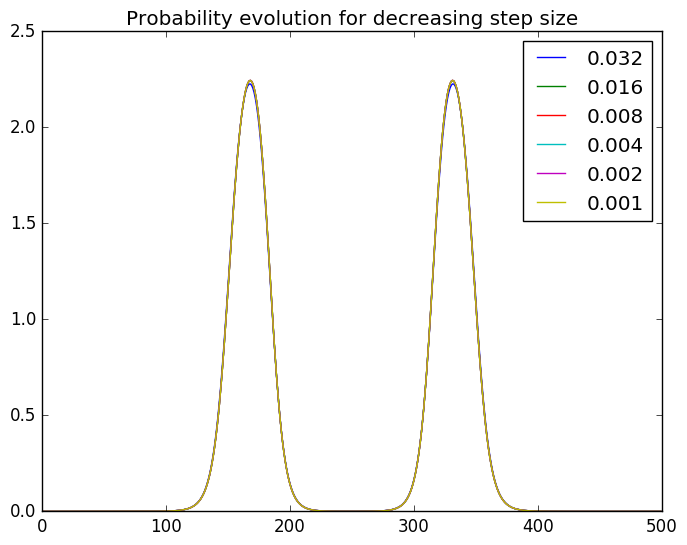

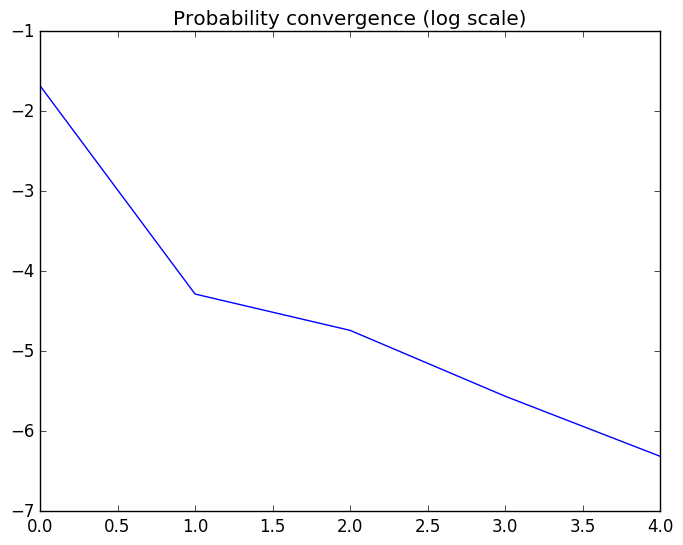

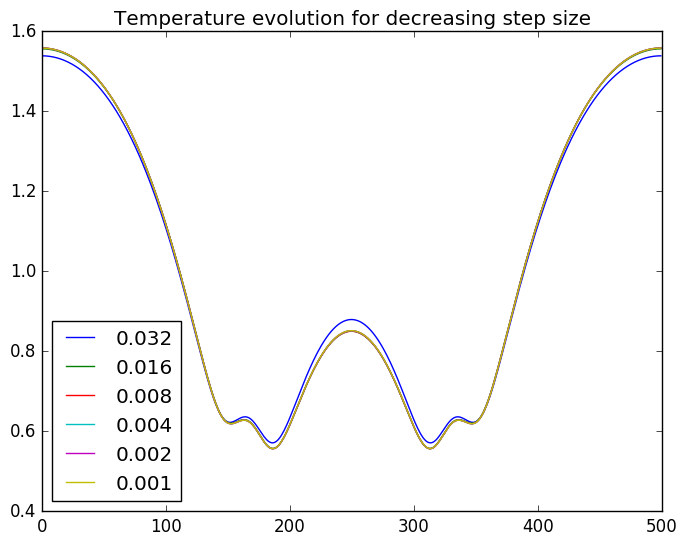

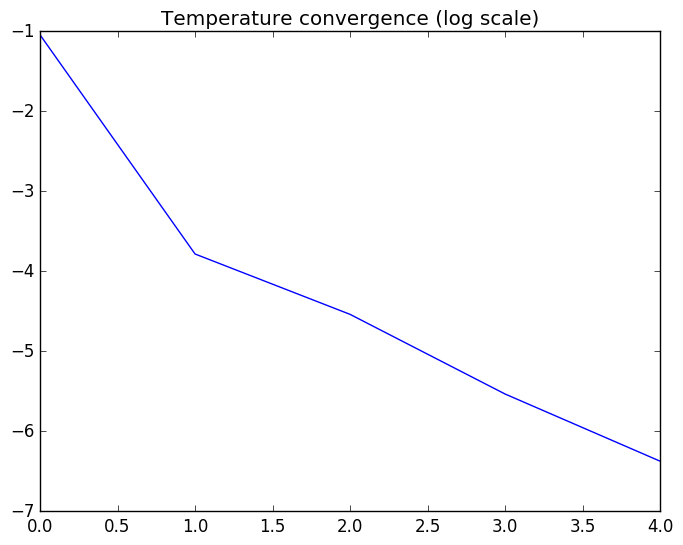

Temperature convergence rate = 9.33382022988168


PyObject <matplotlib.text.Text object at 0x0000000027D6DAC8>

In [6]:
# Test the convergence rate for the system evolution.
scaling = 1e-3
evolveTime = 1.0
dtVec = [32.0, 16.0, 8.0, 4.0, 2.0, 1.0]*scaling
index = 1
alpha = 1e-2
beta = 0.1
energy = energyFun(potential, density, temperature, alpha, xAxis)
Parray = Array(Float64, nPoints, length(dtVec))
Tarray = Array(Float64, nPoints, length(dtVec))
for dt in dtVec
    Parray[:, index], Tarray[:, index] = evolve_system(density, temperature, evolveTime, dt,
            potential, dpotential, alpha, beta, energy, xAxis ; 
    tempBndType = :neumann, probBndType = :periodic)
    index += 1
end

# Calculate the distances between adjacent probability distributions.
norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
println("Probability convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
plot(Parray)
title("Probability evolution for decreasing step size")
legend(dtVec)
figure()
plot(log(norms))
title("Probability convergence (log scale)")
# Calculate the distances between adjacent temperature distributions.
norms = Float64[norm(Tarray[:, i] - Tarray[:, i-1]) for i in 2:length(dtVec)]
println("Temperature convergence rate = ", log(abs((norms[1] - norms[end])/((dtVec[1] - dtVec[end]))/scaling)))
figure()
plot(Tarray)
title("Temperature evolution for decreasing step size")
legend(dtVec, loc = 3)
figure()
plot(log(norms))
title("Temperature convergence (log scale)")

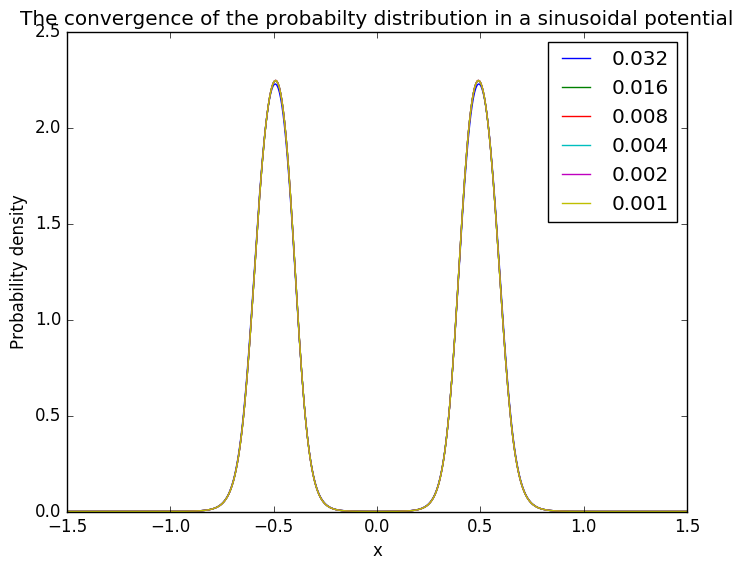

In [7]:
figureDirectory = "C:\\Users\\devja964\\Documents\\Project\\Git\\Honours2016\\Thesis\\Figures"

plot(xAxis, Parray)
legend(dtVec)
title("The convergence of the probabilty distribution in a sinusoidal potential")
xlabel("x")
ylabel("Probability density")
# norms = Float64[norm(Parray[:, i] - Parray[:, i-1]) for i in 2:length(dtVec)]
# plot(log(norms), "b-*")
# title("Difference between sucessive iterations (log scale)")
# xlabel("Step number")
# ylabel("log of the normed difference")
savefig("$(figureDirectory)\\probabilityConvergence.pdf")